In [220]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # import KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
seed=111
path='/Users/Christian/Dropbox/Universitet/TSODAS/TSDS-gruppe-2019/Exam/'

### Loading data

In [201]:
r1=pd.read_pickle(path+'prices_0_200.pkl')
r2=pd.read_pickle(path+'prices_200_578.pkl')
r3=pd.read_pickle(path+'prices_577_777.pkl')
r4=pd.read_pickle(path+'prices_777_1000.pkl')
r5=pd.read_pickle(path+'prices_1000_1500.pkl')
r6=pd.read_pickle(path+'prices_1500_2000.pkl')
r7=pd.read_pickle(path+'prices_2000_3000.pkl')
r8=pd.read_pickle(path+'prices_3000_3240.pkl')
r9=pd.read_pickle(path+'prices_3240_4000.pkl')
r10=pd.read_pickle(path+'prices_4000_.pkl')
#print(len(r1), len(r2), len(r3), len(r4), len(r5), len(r6))
r=r1.append(r2, ignore_index=True)
r=r.append(r3, ignore_index=True)
r=r.append(r4, ignore_index=True)
r=r.append(r5, ignore_index=True)
r=r.append(r6, ignore_index=True)
r=r.append(r7, ignore_index=True)
r=r.append(r8, ignore_index=True)
r=r.append(r9, ignore_index=True)
r=r.append(r10, ignore_index=True)


r.to_pickle('scraping_data.pkl')


In [246]:

r=pd.read_pickle('scraping_data.pkl')
r=r[r['price']!='-']
pred=pd.read_pickle(path+'FlightsML.pkl')
pred_data=r.merge(pred, how='right', left_on=['origin','destination'], right_on=['Origin', 'Dest'])
pred_data=r.drop_duplicates(['origin','destination'])
pred_data['price']=r['price'].str[4:].str.replace('.','')
pred_data['price']=pd.to_numeric(r.price, errors='coerce')


pred_data['label']= r['label'].astype('category')
pred_data['alternative']= r['alternative'].astype('category')
pred_data["alternative_cat"] = r['alternative'].cat.codes
pred_data["label_cat"] = r['label'].cat.codes



pred_data=pred_data[pred_data['count']>=52]
missings = pred_data[pred_data['price'].isna()==True]
missings.to_pickle('missing.pkl')
pred_data = pred_data[pred_data['price'].isna()!=True]

In [247]:
r

,alternative,day,destination,label,origin,price,alternative_cat,label_cat
0,,0,ONT,1 omstigning,SMF,898.0,0,0
1,NaN,0,PDX,Direkte,SMF,1190.0,-1,1
2,NaN,0,PHX,Direkte,SMF,1003.0,-1,1
3,NaN,0,SAN,Direkte,SMF,570.0,-1,1
4,NaN,0,SEA,Direkte,SMF,905.0,-1,1
5,,0,SNA,1 omstigning,SMF,1094.0,0,0
6,NaN,0,LAS,Direkte,SNA,820.0,-1,1
7,Ingen,0,MDW,1 omstigning,SNA,2108.0,1,0
8,NaN,0,OAK,Direkte,SNA,1688.0,-1,1
9,NaN,0,PHX,Direkte,SNA,1096.0,-1,1


In [233]:
pred_data.reset_index(inplace=True)

### Exploring data

In [238]:
X=pred_data[['count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
             'dest_degree','origin_btwns', 'dest_btwns', 'origin_clustcoef', 'dest_clustcoef']]
y=pred_data[['price']]

### Estimating model

In [239]:
kf = KFold(n_splits=10) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 
#KFold(n_splits=10, random_state=None, shuffle=False)

for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 456  457  458 ... 4550 4551 4552] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 2

KeyError: "None of [Int64Index([ 456,  457,  458,  459,  460,  461,  462,  463,  464,  465,\n            ...\n            4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552],\n           dtype='int64', length=4097)] are in the [columns]"

In [248]:
pipe_linear = make_pipeline(Lasso(alpha=1.0,StandardScaler(),random_state=seed))
model=Lasso(alpha=1.0,random_state=seed)
scores = cross_val_score(estimator=model, X=X, y=y , cv=10)
param_range_1 = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

SyntaxError: positional argument follows keyword argument (<ipython-input-248-2e2d708ae7b2>, line 1)

In [242]:
# Validation curve
train_scores, test_scores = validation_curve(
    estimator=model,
    X=X,
    y=y,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o',
    markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(param_range, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=5,
    label='validation accuracy')
plt.fill_between(param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.03])
plt.show()

NameError: name 'param_range' is not defined

In [ ]:
### Grid search
param_range_1 = [0.0001, 0.001, 0.01, 0.1,
    1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
    'svc__gamma': param_range,
    'svc__kernel': ['rbf']}]

### Estimating model

In [ ]:

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) # create an array
y = np.array([1, 2, 3, 4]) # Create another array


# 
lm = linear_model.LinearRegression()


# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=6)
plt.scatter(y, predictions)

accuracy = metrics.r2_score(y, predictions)
print(“Cross-Predicted Accuracy:”, accuracy)


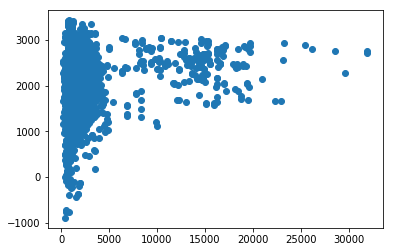

In [243]:
predictions = cross_val_predict(model, X, y, cv=6)
plt.scatter(y, predictions)

KeyboardInterrupt: 

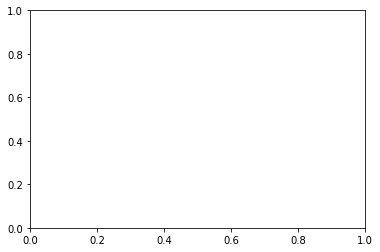

In [245]:
plt.hist(y)
plt.show()